1 files found:
  - 112668.lvm
Loading 112668.lvm...

Processing Shot 112668 - NEW MAPPING
Global trigger time detected at: 10.800 seconds

=== ΔT Summary (with heating event detection) ===
T1 = Baseline Temperature (°C), T2 = Final/Plateau Temperature (°C), ΔT = Temperature Rise (°C)
Analyzing 12 TC(s): TC#1, TC#2, TC#3, TC#4, TC#5, TC#6, TC#7, TC#8, TC#9, TC#10, TC#11, TC#12
          Label  T1 (°C)  T2 (°C)  ΔT (°C)  trigger_t (s)  t1_min (s)  t1_max (s)  t2_t (s)
 Beam Dump TC#1   19.078   19.229    0.151         10.800       4.800       6.800    10.800
 Beam Dump TC#2   19.099   19.392    0.293         10.800       4.800       6.800    10.800
 Beam Dump TC#3   19.047   19.252    0.206         10.800       4.800       6.800    10.800
 Beam Dump TC#4   19.158   19.408    0.250         10.800       4.800       6.800    10.800
 Beam Dump TC#5   19.192   19.415    0.223         10.800       4.800       6.800    10.800
 Beam Dump TC#6   19.180   19.400    0.220         10.800       4.800

/scratch/local/hgajani/20260120.tmp.YYCq6/ipykernel_230066/1788519958.py:497: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


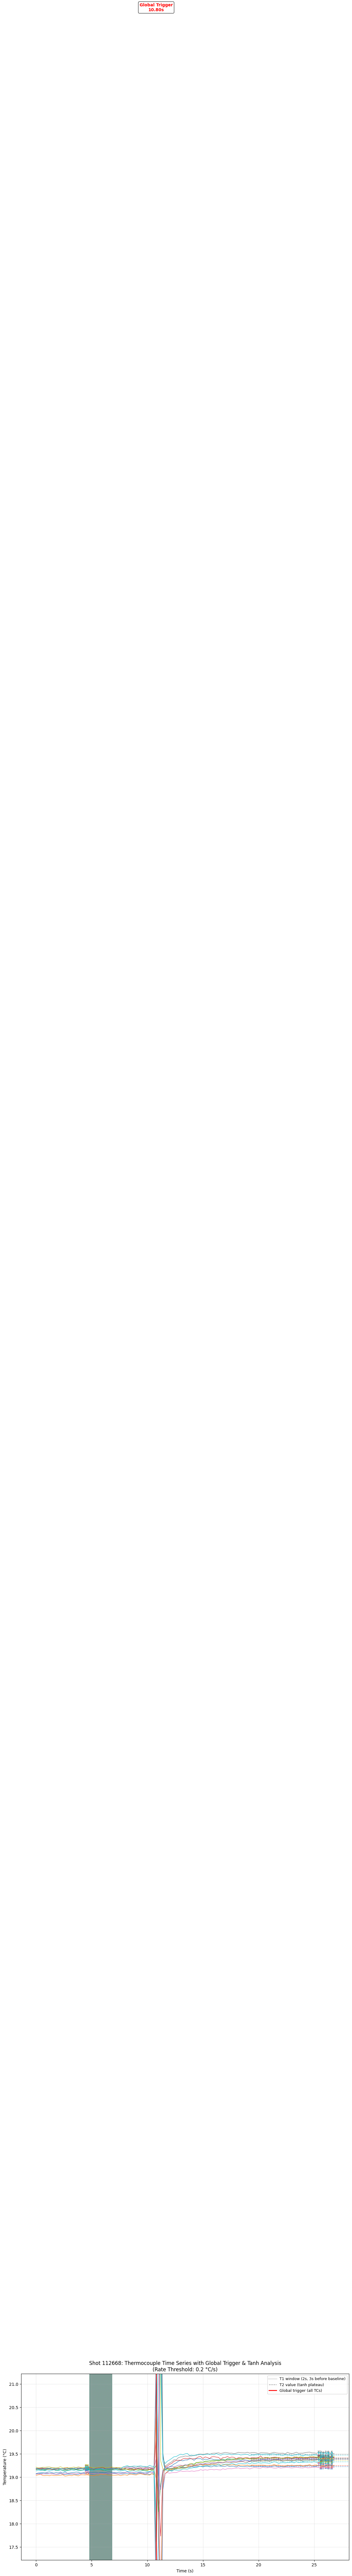

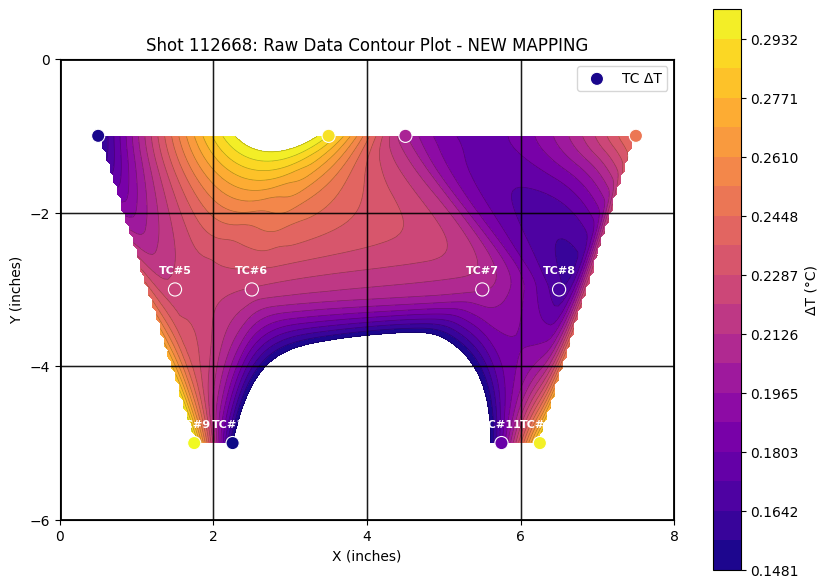

<Figure size 640x480 with 0 Axes>


SUMMARY: Processed 2 shots successfully

=== Average ΔT Across All Shots ===

Processing Shot 112668 - OLD MAPPING

⚠️  No shots were successfully processed!
                 mean   std  count
Label                             
Beam Dump TC#9  0.301 0.000      2
Beam Dump TC#12 0.298 0.000      2
Beam Dump TC#2  0.293 0.000      2
Beam Dump TC#4  0.250 0.000      2
Beam Dump TC#5  0.223 0.000      2
Beam Dump TC#6  0.220 0.000      2
Beam Dump TC#3  0.206 0.000      2
Beam Dump TC#7  0.205 0.000      2
Beam Dump TC#11 0.178 0.000      2
Beam Dump TC#8  0.166 0.000      2
Beam Dump TC#1  0.151 0.000      2
Beam Dump TC#10 0.148 0.000      2

⚠️  No shots were successfully processed!
Global trigger time detected at: 10.800 seconds

=== ΔT Summary - OLD MAPPING ===
Analyzing 24 TC(s): TC#1, TC#1, TC#2, TC#2, TC#3, TC#3, TC#4, TC#4, TC#5, TC#5, TC#6, TC#6, TC#7, TC#7, TC#8, TC#8, TC#9, TC#9, TC#10, TC#10, TC#11, TC#11, TC#12, TC#12

Creating OLD mapping contour plot with 24 raw ΔT measure

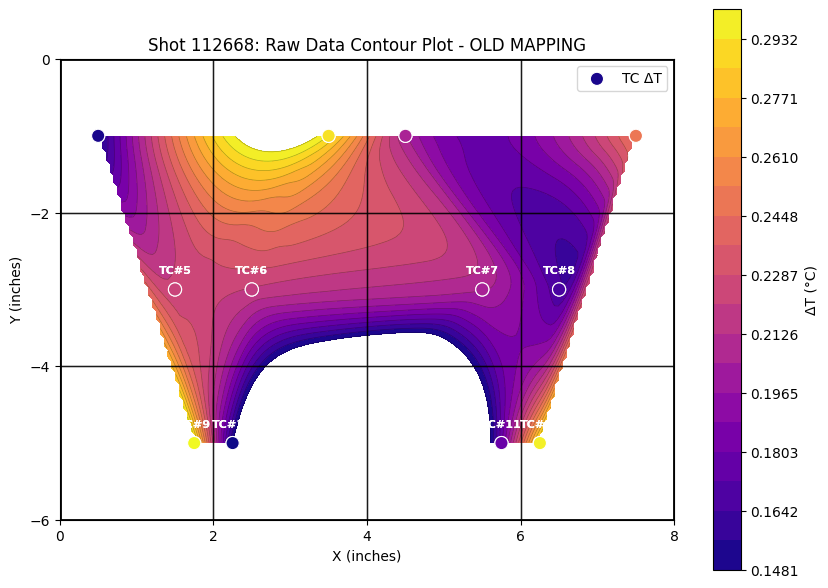


SUMMARY: Processed 3 shots successfully

=== Average ΔT Across All Shots ===
                 mean   std  count
Label                             
Beam Dump TC#9  0.301 0.000      4
Beam Dump TC#12 0.298 0.000      4
Beam Dump TC#2  0.293 0.000      4
Beam Dump TC#4  0.250 0.000      4
Beam Dump TC#5  0.223 0.000      4
Beam Dump TC#6  0.220 0.000      4
Beam Dump TC#3  0.206 0.000      4
Beam Dump TC#7  0.205 0.000      4
Beam Dump TC#11 0.178 0.000      4
Beam Dump TC#8  0.166 0.000      4
Beam Dump TC#1  0.151 0.000      4
Beam Dump TC#10 0.148 0.000      4


In [37]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit

# ================== USER SETTINGS ==================
# where the thermocouple data lives
BASE_FOLDER = Path("/p/ltxdata/thermocouple/LTXB")

# put shot numbers here, leave empty to load all files
shotlist = [
    112668
]

SELECTED_TCS = None 
#SELECTED_TCS = [1, 7, 12]
#SELECTED_TCS = [7]

# heating event detection parameters (replaces fixed time windows)
# This approach automatically detects heating events by finding when |dT/dt| > threshold
# T1 (baseline) = 2-second average taken 3 seconds prior to the original baseline window
# T2 (peak) = tanh plateau temperature
RATE_THRESHOLD = 0.2  # °C/s threshold for detecting significant heating events (beam impact)

# Grid coordinates for thermocouples (inches, 8×6 plate, 2×2 squares)
# centers at x = 0.5/2.5/4.5/6.5/… as you laid out
TC_POSITIONS = {
    "Beam Dump TC#1":  (0.5, -1),
    "Beam Dump TC#2":  (3.5, -1),   
    "Beam Dump TC#3":  (4.5, -1),
    "Beam Dump TC#4":  (7.5, -1),
    "Beam Dump TC#5":  (1.5, -3),
    "Beam Dump TC#6":  (2.5, -3),
    "Beam Dump TC#7":  (5.5, -3),
    "Beam Dump TC#8":  (6.5, -3),
    "Beam Dump TC#9":  (1.75, -5),
    "Beam Dump TC#10": (2.25, -5),
    "Beam Dump TC#11": (5.75, -5),
    "Beam Dump TC#12": (6.25, -5),
}

# Mapping of LVM column indices to labels
# New mapping (correct)
TEMP_TO_LABEL_NEW = {
    32: "Beam Dump TC#1",  33: "Beam Dump TC#2",  34: "Beam Dump TC#3",
    35: "Beam Dump TC#4",  36: "Beam Dump TC#5",  37: "Beam Dump TC#6",
    38: "Beam Dump TC#7", 39: "Beam Dump TC#8",  40: "Beam Dump TC#9",
    41: "Beam Dump TC#10", 42: "Beam Dump TC#11", 43: "Beam Dump TC#12",
}

# Old mapping (for comparison)
TEMP_TO_LABEL_OLD = {
    32: "Beam Dump TC#1",  33: "Beam Dump TC#2",  34: "Beam Dump TC#3",
    35: "Beam Dump TC#4",  36: "Beam Dump TC#5",  39: "Beam Dump TC#6",
    42: "Beam Dump TC#7", 38: "Beam Dump TC#8",  41: "Beam Dump TC#9",
    44: "Beam Dump TC#10", 43: "Beam Dump TC#11", 40: "Beam Dump TC#12"
}
# ====================================================

def find_data_start(path) -> int:
    """LVM files have a header, need to find where the actual data starts"""
    end_idx = -1
    with open(path, "r", errors="replace") as f:
        for i, line in enumerate(f):
            if line.strip() == "***End_of_Header***":
                end_idx = i
    if end_idx == -1:
        raise RuntimeError("***End_of_Header*** not found in file.")
    return end_idx + 1

def window_mask(tvec, a, b):
    return (tvec >= a) & (tvec <= b)

def window_mean(arr, tvec, a, b):
    m = window_mask(tvec, a, b)
    return float(np.mean(arr[m])) if np.any(m) else np.nan

def find_global_trigger(time: np.ndarray, all_tc_data: dict, rate_threshold: float = 0.5):
    """Find global trigger time when beam actually hits and TCs start ramping up."""
    time_series = pd.Series(time)
    
    # Look for sustained heating across multiple TCs
    aggregate_rate = pd.Series(0.0, index=time_series.index)
    tc_count_heating = pd.Series(0, index=time_series.index)
    
    for tc_data in all_tc_data.values():
        temp_series = pd.Series(tc_data)
        temp_series = pd.to_numeric(temp_series, errors='coerce')
        
        # Compute temperature rate
        dtemp = temp_series.diff()
        dt = time_series.diff()
        with np.errstate(divide='ignore', invalid='ignore'):
            rate = dtemp / dt
        
        # Only consider significant positive heating rates
        significant_heating = rate > rate_threshold
        tc_count_heating += significant_heating.astype(int)
        
        # Add to aggregate (only positive rates)
        positive_rate = rate.clip(lower=0)
        aggregate_rate += positive_rate.fillna(0)
    
    # Require multiple TCs to be heating simultaneously (at least 3 TCs)
    min_tcs_heating = max(3, len(all_tc_data) // 3)
    simultaneous_heating = tc_count_heating >= min_tcs_heating
    
    # Also require aggregate rate to be significant
    strong_heating = aggregate_rate > (rate_threshold * min_tcs_heating)
    
    # Combine both conditions
    trigger_condition = simultaneous_heating & strong_heating
    
    if not trigger_condition.any():
        # Fallback: look for any significant aggregate heating
        fallback_condition = aggregate_rate > (rate_threshold * 2)
        if not fallback_condition.any():
            return None
        trigger_idx = fallback_condition[fallback_condition].index[0]
    else:
        trigger_idx = trigger_condition[trigger_condition].index[0]
    
    return float(time_series.iloc[trigger_idx])

def fit_tanh_model(time: np.ndarray, temp: np.ndarray):
    """Fit 3-parameter tanh model: y = A*tanh(k*(x-x0)) + B"""
    from scipy.optimize import curve_fit
    
    def tanh_func(x, A, k, x0, B):
        return A * np.tanh(k * (x - x0)) + B
    
    try:
        # Initial parameter guesses
        temp_min = np.nanmin(temp)
        temp_max = np.nanmax(temp)
        A_guess = (temp_max - temp_min) / 2
        B_guess = (temp_max + temp_min) / 2
        x0_guess = time[len(time)//2]  # middle of time range
        k_guess = 1.0
        
        popt, _ = curve_fit(
            tanh_func, time, temp,
            p0=[A_guess, k_guess, x0_guess, B_guess],
            maxfev=5000,
            bounds=(
                [-np.inf, 0.01, np.min(time), -np.inf],  # lower bounds
                [np.inf, 10.0, np.max(time), np.inf]     # upper bounds
            )
        )
        
        A, k, x0, B = popt
        # T2 is the plateau value: B + A (when tanh approaches 1)
        t2_value = B + A
        return t2_value, popt
        
    except Exception as e:
        # Fallback to max value if fitting fails
        return np.nanmax(temp), None

def analyze_heating_event_v2(time: np.ndarray, temp: np.ndarray, global_trigger_t: float, label: str = ""):
    """Analyze heating event using global trigger and tanh fitting."""
    time_series = pd.Series(time)
    temp_series = pd.Series(pd.to_numeric(temp, errors='coerce'))
    
    if global_trigger_t is None:
        return {'trigger_t': None, 't1_min': None, 't1_max': None,
                't2_t': None, 'deltaT1': np.nan, 'deltaT2': np.nan, 'deltaT': np.nan}
    
    # T1: 2-second average taken 3 seconds prior to the original baseline window
    # Original baseline would be [trigger-1, trigger], so we go 3 seconds before that
    baseline_start = global_trigger_t - 1.0  # Original baseline start
    t1_min = baseline_start - 3.0 - 2.0  # 3 seconds prior, then go back 2 more seconds
    t1_max = baseline_start - 3.0        # 3 seconds prior to original baseline
    
    mask_t1 = (time_series >= t1_min) & (time_series <= t1_max)
    deltaT1 = float(temp_series[mask_t1].mean()) if mask_t1.any() else np.nan
    
    # T2: Use tanh model to find plateau temperature, but add fallback for spikes
    try:
        deltaT2, tanh_params = fit_tanh_model(time, temp)
        deltaT2_tanh = float(deltaT2)
        
        # Also calculate simple max and 95th percentile as comparison
        temp_max = np.nanmax(temp)
        temp_95th = np.nanpercentile(temp, 95)
        
        # If tanh result is much higher than 95th percentile, it might be fitting to a spike
        if deltaT2_tanh > temp_95th * 1.1:  # If tanh is >10% higher than 95th percentile
            deltaT2 = temp_95th  # Use 95th percentile instead
            # This warning will show for ANY TC that has spike issues
            if label:
                print(f"Warning: {label} - Tanh fitting caught a spike (tanh={deltaT2_tanh:.1f}°C, using 95th percentile={temp_95th:.1f}°C)")
        else:
            deltaT2 = deltaT2_tanh
            
    except Exception:
        deltaT2 = np.nan
    
    deltaT = np.nan if np.isnan(deltaT1) or np.isnan(deltaT2) else float(deltaT2 - deltaT1)
    
    return {'trigger_t': global_trigger_t, 't1_min': t1_min, 't1_max': t1_max,
            't2_t': global_trigger_t, 'deltaT1': deltaT1, 'deltaT2': deltaT2, 'deltaT': deltaT}

def find_lvm_file(folder: Path, shot_spec) -> Path | None:
    """Try to find the LVM file for a given shot (handles different formats)"""
    
    shot_str = str(shot_spec).strip()
    
    # check if it's already a full path
    candidate = Path(shot_str)
    if candidate.is_file():
        return candidate
    
    stem = Path(shot_str).stem
    
    # get all lvm files
    lvm_files = [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() == '.lvm']
    
    # try exact match first
    for p in lvm_files:
        if p.stem == stem:
            return p
    
    for p in lvm_files:
        if p.name == shot_str:
            return p
    
    # try prefix match (some files have extra stuff after shot number)
    for p in lvm_files:
        if p.name.startswith(stem):
            return p
    
    return None


# load the files
data_folder = BASE_FOLDER
if shotlist:
    # load specific shots from the list
    lvm_files = []
    for shot_spec in shotlist:
        found = find_lvm_file(data_folder, shot_spec)
        if found:
            lvm_files.append(found)
        else:
            print(f"shot '{shot_spec}' not found in {data_folder}")
    
    if not lvm_files:
        raise RuntimeError(f"no shots found in the folder ->{data_folder}")
else:
    # load everything in the folder
    lvm_files = sorted(data_folder.glob("*.lvm"))
    if not lvm_files:
        raise RuntimeError(f"No .lvm files found in {data_folder}")

print(f"{len(lvm_files)} files found:")
for f in lvm_files:
    print(f"  - {f.name}")

# actually load all the data
all_file_data = {}
for lvm_file in lvm_files:
    try:
        print(f"Loading {lvm_file.name}...")
        start_row = find_data_start(str(lvm_file))
        df = pd.read_csv(lvm_file, sep="\t", skiprows=start_row)
        t = df["X_Value"].astype(float).to_numpy()
        
        # Map columns for BOTH old and new mappings
        col_to_label_new = {}
        col_to_label_old = {}
        
        for idx, label in TEMP_TO_LABEL_NEW.items():
            col = f"Temperature_{idx}"
            if col in df.columns:
                col_to_label_new[col] = label
        
        for idx, label in TEMP_TO_LABEL_OLD.items():
            col = f"Temperature_{idx}"
            if col in df.columns:
                col_to_label_old[col] = label
        
        all_file_data[lvm_file.stem] = (t, df, col_to_label_new, col_to_label_old)
    except Exception as e:
        print(f"Error loading {lvm_file}: {e}")


# Process each shot - NEW MAPPING ONLY
all_results = []
for shot_name, (t, df, col_to_label_new, col_to_label_old) in all_file_data.items():
    print(f"\n{'='*80}")
    print(f"Processing Shot {shot_name} - NEW MAPPING")
    print(f"{'='*80}")
    
    # Use NEW mapping
    col_to_label = col_to_label_new
    rows = []
    
    # ---- Compute T1, T2, ΔT using global trigger and tanh fitting ----
    
    # First, find the global trigger time across all TCs
    all_tc_data = {}
    for col, label in col_to_label.items():
        y = df[col].astype(float).to_numpy()
        all_tc_data[label] = y
    
    global_trigger_t = find_global_trigger(t, all_tc_data, RATE_THRESHOLD)
    
    print(f"Global trigger time detected at: {global_trigger_t:.3f} seconds" if global_trigger_t else "No global trigger detected")
    
    for col, label in col_to_label.items():
        # Extract TC number from label (e.g., "Beam Dump TC#7" -> 7)
        tc_num = int(label.split('#')[1])
        
        # Skip this TC if SELECTED_TCS is set and this TC is not in the list
        if SELECTED_TCS is not None and tc_num not in SELECTED_TCS:
            continue
        
        y = df[col].astype(float).to_numpy()
        
        # Use new analysis method with global trigger and tanh fitting
        event = analyze_heating_event_v2(t, y, global_trigger_t, label)
        
        T1 = event['deltaT1']  # baseline temperature (3-sec average before trigger)
        T2 = event['deltaT2']  # plateau temperature from tanh model
        dT = event['deltaT']   # temperature rise
        
        x, ycoord = TC_POSITIONS[label]
        
        rows.append({
            "Label": label, 
            "T1": T1, 
            "T2": T2, 
            "ΔT": dT, 
            "X": x, 
            "Y": ycoord,
            "trigger_t": event['trigger_t'],
            "t1_min": event['t1_min'],
            "t1_max": event['t1_max'],
            "t2_t": event['t2_t'],
            "Shot": shot_name
        })
    
    summary = pd.DataFrame(rows).sort_values(
        by="Label", key=lambda s: s.str.extract(r'TC#(\d+)').astype(int)[0]
    )
    
    # Check if we have any data after filtering
    if summary.empty:
        print(f" No TCs selected for analysis (SELECTED_TCS = {SELECTED_TCS})")
        continue
    
    print("\n=== ΔT Summary (with heating event detection) ===")
    print("T1 = Baseline Temperature (°C), T2 = Final/Plateau Temperature (°C), ΔT = Temperature Rise (°C)")
    tc_list = ', '.join([f'TC#{int(l.split("#")[1])}' for l in summary['Label']])
    print(f"Analyzing {len(summary)} TC(s): {tc_list}")
    
    # Create a display version with units in column headers
    display_summary = summary[["Label", "T1", "T2", "ΔT", "trigger_t", "t1_min", "t1_max", "t2_t"]].copy()
    display_summary = display_summary.rename(columns={
        "T1": "T1 (°C)", 
        "T2": "T2 (°C)", 
        "ΔT": "ΔT (°C)",
        "trigger_t": "trigger_t (s)",
        "t1_min": "t1_min (s)",
        "t1_max": "t1_max (s)", 
        "t2_t": "t2_t (s)"
    })
    
    print(display_summary.to_string(index=False, float_format=lambda x: f"{x:.3f}" if pd.notna(x) else "nan"))
    
    # Add ranking of TCs from hottest to coldest
    print("\n=== TC Ranking (Hottest to Coldest by ΔT) ===")
    tc_ranking = summary[['Label', 'ΔT']].copy()
    tc_ranking = tc_ranking.sort_values('ΔT', ascending=False)
    tc_ranking['Rank'] = range(1, len(tc_ranking) + 1)
    tc_ranking = tc_ranking[['Rank', 'Label', 'ΔT']].copy()
    tc_ranking['ΔT'] = tc_ranking['ΔT'].apply(lambda x: f"{x:.3f}°C" if pd.notna(x) else "nan")
    
    print(tc_ranking.to_string(index=False))
    
    # -------- 2D Gaussian (for ΔT across the plate) --------
    
    # Check if we have valid ΔT data before attempting Gaussian fit
    xdata = summary["X"].to_numpy()
    ydata = summary["Y"].to_numpy()
    zdata = summary["ΔT"].to_numpy()
    
    valid_dt_mask = np.isfinite(zdata)
    n_valid = np.sum(valid_dt_mask)
    
    if n_valid == 0:
        print("\n⚠️  Warning: No valid ΔT data - skipping spatial analysis")
        print("   This usually means:")
        print("   - The beam heating was not detected (no global trigger)")
        print("   - Temperature analysis failed for all TCs")
        print("   - Wrong shot number or bad data file")
        all_results.append(summary)
    elif n_valid < 3:
        print(f"\n⚠️  Warning: Only {n_valid} valid ΔT measurement(s) - need at least 3 for contour plot")
        print("   Skipping spatial analysis for this shot")
        all_results.append(summary)
    else:
        print(f"\nCreating contour plot with {n_valid} raw ΔT measurements (no Gaussian fitting)...")
    
        print(f"\nCreating contour plot with {n_valid} raw ΔT measurements (no Gaussian fitting)...")
        
        # Create interpolated grid for contour plotting using raw data
        from scipy.interpolate import griddata
        
        # Generate grid for interpolation
        Xgrid, Ygrid = np.meshgrid(np.linspace(0, 8, 160), np.linspace(-6, 0, 120))
        
        # Interpolate raw data onto grid using cubic interpolation
        Zinterp = griddata((xdata, ydata), zdata, (Xgrid, Ygrid), method='cubic', fill_value=np.nan)
        
        # ---------- TWO FIGURES: Time series validation + contour map ----------
        plt.close('all')
        
        # First figure: Time series plot showing T1/T2 windows for validation
        fig1, ax1 = plt.subplots(figsize=(14, 8))
        colors = plt.cm.tab10(np.linspace(0, 1, len(col_to_label)))
        plot_idx = 0
        for i, (col, label) in enumerate(sorted(col_to_label.items(), key=lambda x: int(x[0].split('_')[1]))):
            # Extract TC number and check if we should plot it
            tc_num = int(label.split('#')[1])
            if SELECTED_TCS is not None and tc_num not in SELECTED_TCS:
                continue
                
            y = df[col].astype(float).to_numpy()
            color = colors[plot_idx]
            plot_idx += 1
            
            # Plot the temperature trace
            tc_num = col.split('_')[1]  # Extract TC number from column name
            ax1.plot(t, y, color=color, linewidth=1.2, label=f"{label} (TC{tc_num})", alpha=0.8)
            
            # Find the corresponding row in summary for this TC
            tc_row = summary[summary['Label'] == label].iloc[0]
            
            # Highlight T1 window (3-second baseline before trigger) if it exists
            if pd.notna(tc_row['t1_min']) and pd.notna(tc_row['t1_max']):
                ax1.axvspan(tc_row['t1_min'], tc_row['t1_max'], 
                           facecolor=color, alpha=0.15, edgecolor=color, linewidth=1)
                ax1.text(tc_row['t1_min'], tc_row['T1'], 'T1', 
                        color=color, fontsize=8, ha='right', va='bottom', weight='bold')
            
            # Mark T2 value (from tanh plateau) 
            if pd.notna(tc_row['T2']):
                # Draw horizontal line showing tanh plateau value
                ax1.axhline(tc_row['T2'], color=color, linestyle='--', linewidth=1, alpha=0.6,
                           xmin=0.7, xmax=1.0)  # Only draw on right side
                ax1.text(ax1.get_xlim()[1]*0.95, tc_row['T2'], f'T2={tc_row["T2"]:.1f}\nΔT={tc_row["ΔT"]:.1f}', 
                        color=color, fontsize=8, ha='right', va='center', weight='bold')
        
        # Draw global trigger line (common to all TCs)
        if global_trigger_t is not None:
            ax1.axvline(global_trigger_t, color='red', linestyle='-', linewidth=2, alpha=0.8, zorder=10)
            ax1.text(global_trigger_t, ax1.get_ylim()[1]*0.95, f'Global Trigger\n{global_trigger_t:.2f}s', 
                    color='red', fontsize=10, ha='center', va='top', weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        # Set y-axis range based on the main temperature data, excluding extreme outliers
        all_temps = []
        for col in col_to_label.keys():
            y = df[col].astype(float).to_numpy()
            all_temps.extend(y[np.isfinite(y)])
        
        if all_temps:
            # Use a more focused range around the typical values
            temp_array = np.array(all_temps)
            q25, q75 = np.percentile(temp_array, [25, 75])
            iqr = q75 - q25
            # Set range to median ± 2*IQR, with minimum 2-degree buffer
            median_temp = np.median(temp_array)
            y_range = max(4 * iqr, 4.0)  # At least 4 degrees total range
            ax1.set_ylim(median_temp - y_range/2, median_temp + y_range/2)
        else:
            ax1.set_ylim(4, 16)  # fallback range
        
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Temperature (°C)")
        ax1.set_title(f"Shot {shot_name}: Thermocouple Time Series with Global Trigger & Tanh Analysis\n(Rate Threshold: {RATE_THRESHOLD} °C/s)")
        ax1.grid(True, alpha=0.3)
        
        # Add legend explanation
        legend_elements = [
            plt.Line2D([0], [0], color='gray', linewidth=4, alpha=0.15, label='T1 window (2s, 3s before baseline)'),
            plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=1, label='T2 value (tanh plateau)'),
            plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='Global trigger (all TCs)')
        ]
        ax1.legend(handles=legend_elements, loc='upper right', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Second figure: Raw data contour plot (no Gaussian)
        fig2, ax2 = plt.subplots(figsize=(8.5, 6.0))
        
        # Contour plot with filled contours
        levels = np.linspace(np.nanmin(zdata), np.nanmax(zdata), 20)
        contourf = ax2.contourf(Xgrid, Ygrid, Zinterp, levels=levels, cmap="plasma")
        contour = ax2.contour(Xgrid, Ygrid, Zinterp, levels=levels, colors='k', linewidths=0.5, alpha=0.3)
        cb = plt.colorbar(contourf, ax=ax2, label="ΔT (°C)")
        
        # Overlay plate border (8×6 in)
        ax2.add_patch(Rectangle((0, -6), 8, 6, fill=False, linewidth=2, edgecolor="black", zorder=3))
        
        # Overlay 2×2″ grid lines and square outlines
        for x in np.arange(0, 8.0001, 2.0):
            ax2.axvline(x, color="k", linewidth=0.8, alpha=0.35, zorder=3)
        for y in np.arange(-6, 0.0001, 2.0):
            ax2.axhline(y, color="k", linewidth=0.8, alpha=0.35, zorder=3)
        
        # Crisp square borders
        for x0 in np.arange(0, 8, 2.0):
            for y0 in np.arange(-6, 0, 2.0):
                ax2.add_patch(Rectangle((x0, y0), 2.0, 2.0, fill=False,
                                       linewidth=1.0, edgecolor="k", alpha=0.6, zorder=3.1))
        
        # TC points (measured ΔT) on top for reference
        sc = ax2.scatter(xdata, ydata, c=zdata, cmap="plasma",
                        edgecolors="w", linewidths=0.8, s=90, zorder=4, label="TC ΔT")
        
        # TC labels
        for _, row in summary.iterrows():
            ax2.text(row["X"], row["Y"] + 0.18,
                    row["Label"].replace("Beam Dump ", ""),
                    ha="center", va="bottom", fontsize=8, color="white",
                    weight="bold", zorder=5)
        
        # Axes cosmetics
        ax2.set_xlim(0, 8)
        ax2.set_ylim(-6, 0)
        ax2.set_aspect("equal", adjustable="box")
        ax2.set_xticks([0, 2, 4, 6, 8])
        ax2.set_yticks([0, -2, -4, -6])
        ax2.set_xlabel("X (inches)")
        ax2.set_ylabel("Y (inches)")
        ax2.set_title(f"Shot {shot_name}: Raw Data Contour Plot - NEW MAPPING")
        ax2.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
        
        all_results.append(summary)
        for y0 in np.arange(-6, 0, 2.0):
            ax2.add_patch(Rectangle((x0, y0), 2.0, 2.0, fill=False,
                                   linewidth=1.0, edgecolor="k", alpha=0.6, zorder=3.1))
    
    # TC points (measured ΔT) on top for reference
    sc = ax2.scatter(xdata, ydata, c=zdata, cmap="plasma",
                    edgecolors="w", linewidths=0.8, s=90, zorder=4, label="TC ΔT")
    
    # TC labels
    for _, row in summary.iterrows():
        ax2.text(row["X"], row["Y"] + 0.18,
                row["Label"].replace("Beam Dump ", ""),
                ha="center", va="bottom", fontsize=8, color="white",
                weight="bold", zorder=5)
    
    # Axes cosmetics
    ax2.set_xlim(0, 8)
    ax2.set_ylim(-6, 0)
    ax2.set_aspect("equal", adjustable="box")
    ax2.set_xticks([0, 2, 4, 6, 8])
    ax2.set_yticks([0, -2, -4, -6])
    ax2.set_xlabel("X (inches)")
    ax2.set_ylabel("Y (inches)")
    ax2.set_title(f"Shot {shot_name}: Raw Data Contour Plot of Beam Footprint (ΔT) with 2×2″ Grid")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    
    all_results.append(summary)

# Combine results from all shots
if all_results:
    combined_results = pd.concat(all_results, ignore_index=True)
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: Processed {len(all_results)} shots successfully")
    print(f"{'='*80}")
    
    # Show average ΔT across all shots for each TC
    print("\n=== Average ΔT Across All Shots ===")
    avg_by_tc = combined_results.groupby('Label')['ΔT'].agg(['mean', 'std', 'count'])
    print(f"\n{'='*80}")
    print(f"Processing Shot {shot_name} - OLD MAPPING")
    print(f"{'='*80}")
    print("\n⚠️  No shots were successfully processed!")

# Now process OLD mapping separately for comparison
for shot_name, (t, df, col_to_label_new, col_to_label_old) in all_file_data.items():
    avg_by_tc = avg_by_tc.sort_values('mean', ascending=False)
    print(avg_by_tc.to_string(float_format=lambda x: f"{x:.3f}"))
else:
    print("\n⚠️  No shots were successfully processed!")# Now process OLD mapping separately for comparisonfor shot_name, (t, df, col_to_label_new, col_to_label_old) in all_file_data.items():    print(f"\n{'='*80}")    print(f"Processing Shot {shot_name} - OLD MAPPING")    print(f"{'='*80}")        # Use OLD mapping    col_to_label = col_to_label_old    rows = []        # ---- Compute T1, T2, ΔT using global trigger and tanh fitting ----        # First, find the global trigger time across all TCs    all_tc_data = {}    for col, label in col_to_label.items():
    y = df[col].astype(float).to_numpy()
    all_tc_data[label] = y
    
    global_trigger_t = find_global_trigger(t, all_tc_data, RATE_THRESHOLD)
    
    print(f"Global trigger time detected at: {global_trigger_t:.3f} seconds" if global_trigger_t else "No global trigger detected")
    
    for col, label in col_to_label.items():
        # Extract TC number from label (e.g., "Beam Dump TC#7" -> 7)
        tc_num = int(label.split('#')[1])
        
        # Skip this TC if SELECTED_TCS is set and this TC is not in the list
        if SELECTED_TCS is not None and tc_num not in SELECTED_TCS:
            continue
        
        y = df[col].astype(float).to_numpy()
        
        # Use new analysis method with global trigger and tanh fitting
        event = analyze_heating_event_v2(t, y, global_trigger_t, label)
        
        T1 = event['deltaT1']
        T2 = event['deltaT2']
        dT = event['deltaT']
        
        x, ycoord = TC_POSITIONS[label]
        
        rows.append({
            "Label": label, 
            "T1": T1, 
            "T2": T2, 
            "ΔT": dT, 
            "X": x, 
            "Y": ycoord,
            "trigger_t": event['trigger_t'],
            "t1_min": event['t1_min'],
            "t1_max": event['t1_max'],
            "t2_t": event['t2_t'],
            "Shot": shot_name
        })
    
    summary_old = pd.DataFrame(rows).sort_values(
        by="Label", key=lambda s: s.str.extract(r'TC#(\d+)').astype(int)[0]
    )
    
    if summary_old.empty:
        print(f" No TCs selected for analysis (SELECTED_TCS = {SELECTED_TCS})")
    else:
        print("\n=== ΔT Summary - OLD MAPPING ===")
        tc_list = ', '.join([f'TC#{int(l.split("#")[1])}' for l in summary_old['Label']])
        print(f"Analyzing {len(summary_old)} TC(s): {tc_list}")
        
        # Get data for contour plot
        xdata_old = summary_old["X"].to_numpy()
        ydata_old = summary_old["Y"].to_numpy()
        zdata_old = summary_old["ΔT"].to_numpy()
        
        valid_dt_mask = np.isfinite(zdata_old)
        n_valid = np.sum(valid_dt_mask)
        
        if n_valid < 3:
            print(f"\n⚠️  Warning: Only {n_valid} valid ΔT measurement(s) - skipping OLD mapping plot")
        else:
            print(f"\nCreating OLD mapping contour plot with {n_valid} raw ΔT measurements...")
            
            # Create interpolated grid for contour plotting
            from scipy.interpolate import griddata
            
            Xgrid_old, Ygrid_old = np.meshgrid(np.linspace(0, 8, 160), np.linspace(-6, 0, 120))
            Zinterp_old = griddata((xdata_old, ydata_old), zdata_old, (Xgrid_old, Ygrid_old), method='cubic', fill_value=np.nan)
            
            # Create OLD mapping contour plot
            fig3, ax3 = plt.subplots(figsize=(8.5, 6.0))
            
            levels_old = np.linspace(np.nanmin(zdata_old), np.nanmax(zdata_old), 20)
            contourf_old = ax3.contourf(Xgrid_old, Ygrid_old, Zinterp_old, levels=levels_old, cmap="plasma")
            contour_old = ax3.contour(Xgrid_old, Ygrid_old, Zinterp_old, levels=levels_old, colors='k', linewidths=0.5, alpha=0.3)
            cb_old = plt.colorbar(contourf_old, ax=ax3, label="ΔT (°C)")
            
            # Overlay plate border
            ax3.add_patch(Rectangle((0, -6), 8, 6, fill=False, linewidth=2, edgecolor="black", zorder=3))
            
            # Overlay grid
            for x in np.arange(0, 8.0001, 2.0):
                ax3.axvline(x, color="k", linewidth=0.8, alpha=0.35, zorder=3)
            for y in np.arange(-6, 0.0001, 2.0):
                ax3.axhline(y, color="k", linewidth=0.8, alpha=0.35, zorder=3)
            
            # Square borders
            for x0 in np.arange(0, 8, 2.0):
                for y0 in np.arange(-6, 0, 2.0):
                    ax3.add_patch(Rectangle((x0, y0), 2.0, 2.0, fill=False,
                                           linewidth=1.0, edgecolor="k", alpha=0.6, zorder=3.1))
            
            # TC points
            sc_old = ax3.scatter(xdata_old, ydata_old, c=zdata_old, cmap="plasma",
                                edgecolors="w", linewidths=0.8, s=90, zorder=4, label="TC ΔT")
            
            # TC labels
            for _, row in summary_old.iterrows():
                ax3.text(row["X"], row["Y"] + 0.18,
                        row["Label"].replace("Beam Dump ", ""),
                        ha="center", va="bottom", fontsize=8, color="white",
                        weight="bold", zorder=5)
            
            # Axes cosmetics
            ax3.set_xlim(0, 8)
            ax3.set_ylim(-6, 0)
            ax3.set_aspect("equal", adjustable="box")
            ax3.set_xticks([0, 2, 4, 6, 8])
            ax3.set_yticks([0, -2, -4, -6])
            ax3.set_xlabel("X (inches)")
            ax3.set_ylabel("Y (inches)")
            ax3.set_title(f"Shot {shot_name}: Raw Data Contour Plot - OLD MAPPING")
            ax3.legend(loc="upper right")
            plt.tight_layout()
            plt.show()
            
            all_results.append(summary_old)

# Combine results from all shots
if all_results:
    combined_results = pd.concat(all_results, ignore_index=True)
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: Processed {len(all_results)} shots successfully")
    print(f"{'='*80}")
    
    # Show average ΔT across all shots for each TC
    print("\n=== Average ΔT Across All Shots ===")
    avg_by_tc = combined_results.groupby('Label')['ΔT'].agg(['mean', 'std', 'count'])
    avg_by_tc = avg_by_tc.sort_values('mean', ascending=False)
    print(avg_by_tc.to_string(float_format=lambda x: f"{x:.3f}"))
else:
    print("\n⚠️  No shots were successfully processed!")

Loading OLD mapping data for shot 112668...
Global trigger time (OLD): 10.800 s
Creating OLD mapping contour-only plot with 12 ΔT measurements...


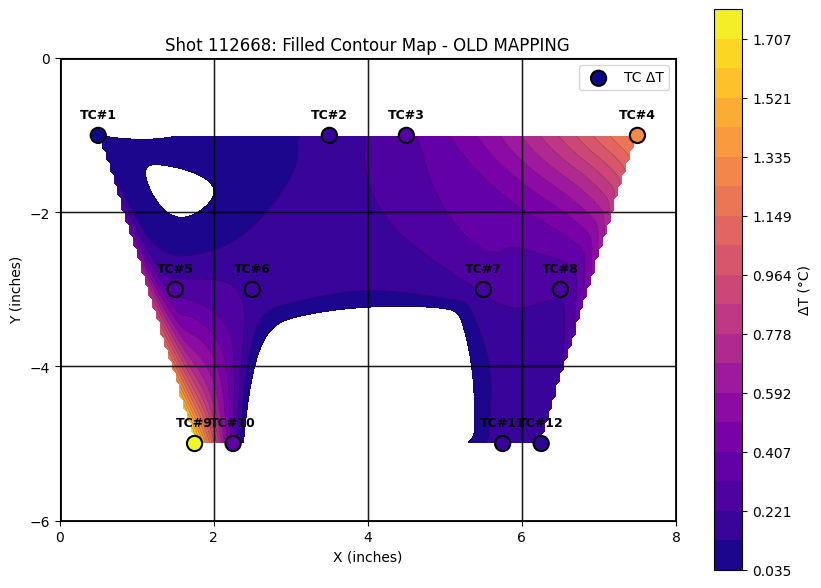


✓ Filled contour map created for OLD mapping


In [45]:
# Create contour-only plot using OLD thermocouple mapping
TEMP_TO_LABEL_OLD = {
    32: "Beam Dump TC#1",  33: "Beam Dump TC#2",  34: "Beam Dump TC#3",
    35: "Beam Dump TC#4",  36: "Beam Dump TC#5",  39: "Beam Dump TC#6",
    42: "Beam Dump TC#7", 38: "Beam Dump TC#8",  41: "Beam Dump TC#9",
    44: "Beam Dump TC#10", 43: "Beam Dump TC#11", 40: "Beam Dump TC#12"
}

# Load data file with OLD mapping
print(f"Loading OLD mapping data for shot {shot_name}...")
old_lvm_file = BASE_FOLDER / f"{shot_name}.lvm"

if not old_lvm_file.exists():
    print(f"⚠️  OLD TC file not found: {old_lvm_file}")
else:
    # Read the LVM file
    start_row_old = find_data_start(old_lvm_file)
    df_old = pd.read_csv(
        old_lvm_file, 
        sep='\t', 
        skiprows=start_row_old,
        header=None,
        on_bad_lines='skip'
    )
    
    # Set column names
    df_old.columns = [f"COL{i}" for i in range(len(df_old.columns))]
    
    # Rename TIME and TEMP columns based on OLD mapping
    df_old.rename(columns={"COL0": "TIME"}, inplace=True)
    for tc_num in TEMP_TO_LABEL_OLD.keys():
        if f"COL{tc_num}" in df_old.columns:
            df_old.rename(columns={f"COL{tc_num}": f"TEMP{tc_num}"}, inplace=True)
    
    # Convert TIME column to numeric and extract time array
    df_old['TIME'] = pd.to_numeric(df_old['TIME'], errors='coerce')
    t_old = df_old['TIME'].to_numpy()
    
    # Create column mapping for old TCs
    col_to_label_old_plot = {f"TEMP{tc_num}": label for tc_num, label in TEMP_TO_LABEL_OLD.items()}
    
    # Find global trigger for OLD data
    all_tc_data_old = {}
    for col, label in col_to_label_old_plot.items():
        if col in df_old.columns:
            y = pd.to_numeric(df_old[col], errors='coerce').to_numpy()
            all_tc_data_old[label] = y
    
    global_trigger_t_old = find_global_trigger(t_old, all_tc_data_old, RATE_THRESHOLD)
    print(f"Global trigger time (OLD): {global_trigger_t_old:.3f} s" if global_trigger_t_old else "No trigger detected")
    
    # Process OLD mapping for contour plot
    rows_old = []
    
    for col, label in col_to_label_old_plot.items():
        if col not in df_old.columns:
            continue
        
        # Extract TC number from label
        tc_num = int(label.split('#')[1])
        
        # Skip this TC if SELECTED_TCS is set and this TC is not in the list
        if SELECTED_TCS is not None and tc_num not in SELECTED_TCS:
            continue
        
        y = pd.to_numeric(df_old[col], errors='coerce').to_numpy()
        
        # Use new analysis method with global trigger and tanh fitting
        event = analyze_heating_event_v2(t_old, y, global_trigger_t_old, label)
        
        T1 = event['deltaT1']
        T2 = event['deltaT2']
        dT = event['deltaT']
        
        x, ycoord = TC_POSITIONS[label]
        
        rows_old.append({
            "Label": label, 
            "T1": T1, 
            "T2": T2, 
            "ΔT": dT, 
            "X": x, 
            "Y": ycoord,
            "trigger_t": event['trigger_t'],
            "t1_min": event['t1_min'],
            "t1_max": event['t1_max'],
            "t2_t": event['t2_t'],
            "Shot": shot_name
        })
    
    if not rows_old:
        print("No data available for OLD mapping contour plot")
    else:
        summary_old_plot = pd.DataFrame(rows_old).sort_values(
            by="Label", key=lambda s: s.str.extract(r'TC#(\d+)').astype(int)[0]
        )
        
        # Get data for contour plot
        xdata_old_plot = summary_old_plot["X"].to_numpy()
        ydata_old_plot = summary_old_plot["Y"].to_numpy()
        zdata_old_plot = summary_old_plot["ΔT"].to_numpy()
        
        valid_dt_mask = np.isfinite(zdata_old_plot)
        n_valid = np.sum(valid_dt_mask)
        
        if n_valid < 3:
            print(f"⚠️  Warning: Only {n_valid} valid ΔT measurement(s) - need at least 3 for contour plot")
        else:
            print(f"Creating OLD mapping contour-only plot with {n_valid} ΔT measurements...")
            
            # Create interpolated grid for contour plotting
            from scipy.interpolate import griddata
            
            Xgrid_old_plot, Ygrid_old_plot = np.meshgrid(np.linspace(0, 8, 160), np.linspace(-6, 0, 120))
            Zinterp_old_plot = griddata((xdata_old_plot, ydata_old_plot), zdata_old_plot, 
                                         (Xgrid_old_plot, Ygrid_old_plot), method='cubic', fill_value=np.nan)
            
            # Create OLD mapping filled contour map
            fig_contour, ax_contour = plt.subplots(figsize=(8.5, 6.0))
            
            levels_old_plot = np.linspace(np.nanmin(zdata_old_plot), np.nanmax(zdata_old_plot), 20)
            
            # Filled contour map
            contourf_old = ax_contour.contourf(Xgrid_old_plot, Ygrid_old_plot, Zinterp_old_plot, 
                                               levels=levels_old_plot, cmap='plasma')
            contour_old = ax_contour.contour(Xgrid_old_plot, Ygrid_old_plot, Zinterp_old_plot, 
                                             levels=levels_old_plot, colors='k', linewidths=0.5, alpha=0.3)
            
            # Add colorbar for the filled contour
            cb_contour = plt.colorbar(contourf_old, ax=ax_contour, label="ΔT (°C)")
            
            # Overlay plate border
            ax_contour.add_patch(Rectangle((0, -6), 8, 6, fill=False, linewidth=2, edgecolor="black", zorder=3))
            
            # Overlay grid
            for x in np.arange(0, 8.0001, 2.0):
                ax_contour.axvline(x, color="k", linewidth=0.8, alpha=0.35, zorder=3)
            for y in np.arange(-6, 0.0001, 2.0):
                ax_contour.axhline(y, color="k", linewidth=0.8, alpha=0.35, zorder=3)
            
            # Square borders
            for x0 in np.arange(0, 8, 2.0):
                for y0 in np.arange(-6, 0, 2.0):
                    ax_contour.add_patch(Rectangle((x0, y0), 2.0, 2.0, fill=False,
                                           linewidth=1.0, edgecolor="k", alpha=0.6, zorder=3.1))
            
            # TC points
            sc_contour = ax_contour.scatter(xdata_old_plot, ydata_old_plot, c=zdata_old_plot, cmap="plasma",
                                edgecolors="k", linewidths=1.5, s=120, zorder=4, label="TC ΔT")
            
            # TC labels
            for _, row in summary_old_plot.iterrows():
                ax_contour.text(row["X"], row["Y"] + 0.18,
                        row["Label"].replace("Beam Dump ", ""),
                        ha="center", va="bottom", fontsize=9, color="black",
                        weight="bold", zorder=5)
            
            # Axes cosmetics
            ax_contour.set_xlim(0, 8)
            ax_contour.set_ylim(-6, 0)
            ax_contour.set_aspect("equal", adjustable="box")
            ax_contour.set_xticks([0, 2, 4, 6, 8])
            ax_contour.set_yticks([0, -2, -4, -6])
            ax_contour.set_xlabel("X (inches)")
            ax_contour.set_ylabel("Y (inches)")
            ax_contour.set_title(f"Shot {shot_name}: Filled Contour Map - OLD MAPPING")
            ax_contour.legend(loc="upper right")
            plt.tight_layout()
            plt.show()
            
            print(f"\n✓ Filled contour map created for OLD mapping")